In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,spearmanr
from datetime import datetime
from sklearn.metrics import mean_squared_error 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.distributions import empirical_distribution
#My stuff starts In[37]

In [2]:
plPrice = pd.read_csv('plPrice17-19.csv')
plPrice.drop(columns = ['Hong Kong 8:30','Hong Kong 14:00','New York 9:30'],inplace = True)
plPrice.rename(columns = {'London 09:00':'Price'},inplace= True)
plPrice.dropna(how='any',inplace = True)
plPrice.to_csv('plPrice17-20Updated.csv')
plPrice['Date'] = pd.to_datetime(plPrice['Date'])
plPrice=plPrice[plPrice['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()]
plPrice19=plPrice[plPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]

In [3]:
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]

simulatedFTSE = pd.read_csv('fullSimulatedFTSEPrice.csv')
simulatedFTSE.rename(columns = {'Unnamed: 0':'Date'},inplace = True)
simulatedFTSE['Date'] = pd.to_datetime(simulatedFTSE['Date'])


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)


In [11]:
def tiltFTSE(tilt):
    #iterates over quarter in period
    tilt = tilt.divide(100)
    
    for idx, quarter in enumerate(quarterNames):
        #print(quarter)
        #gets index (trading days) for each quarter
        index = FTSE[(FTSE['Date'] >= quarterCutOffDates[idx]) & (FTSE['Date'] < quarterCutOffDates[idx+1])].Date.values

        #imports data for that quarter
        stockWeightsOpen = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Open.csv'.format(quarter))
        stockWeightsOpen.drop(columns = 'Unnamed: 0', inplace = True)
        #print(stockWeightsOpen)
        stockWeightsClose = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Close.csv'.format(quarter))
        stockWeightsClose.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsOpen = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Open.csv'.format(quarter))
        totalMCsOpen.drop(columns = 'Unnamed: 0', inplace = True)
        
        totalMCsClose = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Close.csv'.format(quarter))
        totalMCsClose.drop(columns = 'Unnamed: 0', inplace = True)

        #stockMarketCapsEachQuarterOpen = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Open.csv'.format(quarter))
        #stockMarketCapsEachQuarterOpen.drop(columns = 'Unnamed: 0', inplace = True)
        
        #stockMarketCapsEachQuarterClose = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Close.csv'.format(quarter))
        #stockMarketCapsEachQuarterClose.drop(columns = 'Unnamed: 0', inplace = True)

        
        totalMCsCloseLast = totalMCsClose['0'].iloc[-1]
        sumWeights = totalMCsOpen
        
        stockidx = 0
        
        for stock in FTSEStocksEachQuarter[quarter]:
            tiltStock = tilt.loc[stock][0]
            weightClose = stockWeightsClose[stock].iloc[-1]
            
            #applies tilt to weights and then sums new weights 
            #weight cannot be <0 
            if stockidx == 0:
                sumWeights = pd.Series([(-weight) if tiltStock+weight<0 else tiltStock + weight for weight in stockWeightsOpen[stock]])
                
                
                if tilt.loc[stock][0] + weightClose < 0:
                    sumWeightsLastClose = -weightClose
                else:
                    sumWeightsLastClose = tiltStock + weightClose
            else:
                sumWeights += pd.Series([(-weight) if tiltStock+weight<0 else tiltStock + weight for weight in stockWeightsOpen[stock]])
                
                if tilt.loc[stock][0] + weightClose < 0:
                    sumWeightsLastClose -= weightClose
                else:
                    sumWeightsLastClose += tiltStock + weightClose
           
            stockidx += 1
            
            
        #gets new market caps based off updated weights
        newTotalMarketCapsOpen = totalMCsOpen['0']* sumWeights
        #finds last closing mc of quarter for index divisor calc
        closeTotalMC = sumWeightsLastClose*totalMCsClose['0'].iloc[-1]
        
        if idx == 0:
            #for the first quarter the reference price is the real FTSE price from that day - abitrary starting point
            indexDivisorForQuarter = newTotalMarketCapsOpen.iloc[0]/(FTSE[FTSE['Date'] == quarterCutOffDates[idx]]['Open'].values[0])
        else:
            indexDivisorForQuarter = newTotalMarketCapsOpen.iloc[0]/quarterClose
        #print(indexDivisorForQuarter,closeTotalMC)

        quarterClose = closeTotalMC / indexDivisorForQuarter
        #calculates new tilted price using index divisor and tilted market caps
        newTotalMarketCapsOpen = newTotalMarketCapsOpen.to_frame()
        FTSEPriceQuarterly = newTotalMarketCapsOpen.divide(indexDivisorForQuarter).set_index(index, drop=True)
        FTSEPriceQuarterly.rename(columns={0:"Open"}, inplace=True)
        #FTSEPriceQuarterly['Close'] = newTotalMarketCapsClose.divide(indexDivisorForQuarter).set_index(index, drop=True)


        if idx == 0:
            FTSEPrice3yr = FTSEPriceQuarterly

        else:
            FTSEPrice3yr = FTSEPrice3yr.append(FTSEPriceQuarterly)

    FTSEPrice3yr.rename(columns={'0':"Open"}, inplace=True)
    
    return FTSEPrice3yr

In [5]:

FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)

def jackTilt(catTilts,tiltWeights):
    # Assigns the catTilts to each company and runs tiltFTSE.
    minePd,mineOth,autoRel,autoCar,defenceInd,finSec,jMat,noInt=catTilts
    tiltWeights['Weights'] = [
    minePd	#AAL
    ,noInt	#ABF
    ,noInt	#ADM
    ,noInt	#AHT
    ,mineOth #ANTO
    ,autoCar	#AUTO
    ,noInt	#AV.
    ,noInt	#AVV
    ,noInt	#AZN
    ,defenceInd	#BA.
    ,defenceInd	#BAB
    ,noInt	#BARC
    ,noInt	#BATS
    ,noInt	#BDEV
    ,mineOth#BHP
    ,noInt	#BKG
    ,noInt	#BLND
    ,autoRel #BNZL
    ,noInt	#BP
    ,noInt	#BRBY
    ,noInt	#BT-A
    ,noInt	#CCH
    ,noInt	#CCL
    ,noInt	#CNA
    ,noInt	#CPG
    ,noInt	#CRDA
    ,noInt	#CRH
    ,noInt	#CTEC
    ,noInt	#DCC
    ,noInt	#DGE
    ,noInt	#DLG
    ,mineOth #EVR
    ,noInt	#EXPN
    ,autoRel #EZJ
    ,noInt	#FERG
    ,noInt	#FLTR
    ,mineOth #FRES
    ,noInt	#GFS
    ,mineOth #GLEN
    ,noInt	#GSK
    ,noInt	#GVC
    ,noInt	#HIK
    ,finSec #HL.
    ,noInt	#HLMA
    ,noInt	#HMSO
    ,finSec #HSBA
    ,noInt	#HSX
    ,noInt	#IAG
    ,noInt	#IHG
    ,finSec #III
    ,noInt	#IMB
    ,noInt	#INF
    ,noInt	#ITRK
    ,noInt	#ITV
    ,noInt	#JD.
    ,noInt	#JE.
    ,jMat	#JMAT
    ,noInt	#KGF
    ,noInt	#LAND
    ,finSec	#LGEN
    ,finSec	#LLOY
    ,finSec	#LSE
    ,noInt	#MCRO
    ,noInt	#MDC
    ,defenceInd	#MGGT
    ,noInt	#MKS
    ,noInt	#MNDI
    ,finSec #MNG
    ,finSec #MRO
    ,noInt	#MRW
    ,noInt	#NG.
    ,noInt	#NMC
    ,noInt	#NXT
    ,autoRel #OCDO
    ,finSec #PFG
    ,noInt	#PHNX
    ,minePd	#POLY
    ,finSec #PRU
    ,noInt	#PSN
    ,noInt	#PSON
    ,noInt	#RB.
    ,finSec #RBS
    ,noInt	#RDSA
    ,noInt	#RDSB
    ,noInt	#REL
    ,mineOth #RIO
    ,defenceInd	#RMG
    ,noInt	#RMV
    ,defenceInd	#RR.
    ,noInt	#RSA
    ,noInt	#RTO
    ,noInt	#SBRY
    ,finSec #SDR
    ,noInt	#SGE
    ,noInt	#SGRO
    ,noInt	#SKG
    ,finSec #SLA
    ,noInt	#SMDS
    ,mineOth #SMIN
    ,finSec #SMT
    ,noInt	#SN.
    ,noInt	#SPX
    ,noInt	#SSE
    ,finSec #STAN
    ,finSec #STJ
    ,noInt	#SVT
    ,noInt	#TSCO
    ,noInt	#TUI
    ,noInt	#TW.
    ,noInt	#ULVR
    ,noInt	#UU.
    ,noInt	#VOD
    ,noInt	#WG.
    ,noInt	#WPP
    ,noInt	#WTB
    ]
    return tiltFTSE(tiltWeights)


In [8]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)

#My Traditional Method Values.
minePd = 2
mineOth = 1.5
autoRel = -0.5
autoCar = -2
defenceInd = -1
finSec =  0.5
jMat = 1
noInt = 0
catTilts = [minePd,mineOth,autoRel,autoCar
            ,defenceInd,finSec,jMat,noInt]
jackTiltNos = [2,1.5,-0.5,-2,-1,0.5,1,0]
tiltedFTSE = jackTilt(catTilts,tiltWeights)


In [27]:
def findBestTiltCat(catTilt,tiltWeights):
    #Finds the best tilt for the first non-zero item in catTilt.
    currentVal = 0 
    counter=-1
    while currentVal == 0:
        currentVal = catTilt[counter+1]
        counter+=1
    bestI = 0
    bestCorr = 0
    for i in np.linspace(-2,2,41):
        catTilt[counter]=i
        tiltedFTSE = jackTilt(catTilt,tiltWeights)

        #Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
        tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
        tiltedFTSE2018 = tiltedFTSE[(tiltedFTSE.index > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (tiltedFTSE.index < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
        #Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
        #
        plPrice2018 = plPrice[(plPrice.Date < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (plPrice.Date > datetime.strptime('Dec 16, 2017','%b %d, %Y'))]
        #find correlation between tilted FTSE and palladium price
        correlationTiltedFTSE = pearsonr(tiltedFTSE2018['Open'].values,plPrice2018['Price'].values)
        #Note: currently set to find strongest absolute correlation.
        if correlationTiltedFTSE[0]>bestCorr:
            bestI=i
            bestCorr = correlationTiltedFTSE[0]
    print(round(bestI,1))
    return round(bestI,1)

In [28]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
#Find the best tilt for each category
#Warning: Takes quite a while... Don't run unless trying different findBestTiltCat approach
bestMinePd = findBestTiltCat([1,0,0,0,0,0,0,0],tiltWeights)
bestmineOth = findBestTiltCat([0,1,0,0,0,0,0,0],tiltWeights)
bestautoRel = findBestTiltCat([0,0,1,0,0,0,0,0],tiltWeights)
bestautoCar = findBestTiltCat([0,0,0,1,0,0,0,0],tiltWeights)
bestdefenceInd= findBestTiltCat([0,0,0,0,1,0,0,0],tiltWeights)
bestfinSec =  findBestTiltCat([0,0,0,0,0,1,0,0],tiltWeights)
bestjMat = findBestTiltCat([0,0,0,0,0,0,1,0],tiltWeights)
bestnoInt = findBestTiltCat([0,0,0,0,0,0,0,1],tiltWeights)
print([bestMinePd,bestmineOth,bestautoRel,bestautoCar,bestdefenceInd,bestfinSec,bestjMat,bestnoInt])

0
0
0
0
0
0
0
-1.3
[0, 0, 0, 0, 0, 0, 0, -1.3]


In [15]:
pearsonVals = []
plPrice19=plPrice[plPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]

for stock in fullStockListDf['0'].values:
    if stock[-1] == '.':
            stockPrice = pd.read_csv(f'stockCSVs/{stock}L17-20.csv')
    else:
        stockPrice = pd.read_csv(f'stockCSVs/{stock}.L17-20.csv')
    stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
    stockPrice=stockPrice[stockPrice['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()]
    stockPrice=stockPrice[stockPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]
    
    p = pearsonr(stockPrice['Open'].values,plPrice19['Price'].values)
    pearsonVals.append((p[0]))
corrCoeffs = pd.DataFrame({'Company':fullStockListDf['0'].values,'Pearson':pearsonVals})
minePd = 2
mineOth = 1.5
autoRel = -0.5
autoCar = -2
defenceInd = -1
finSec =  0.5
jMat = 1
noInt = 0
groupings = [
minePd	#AAL
,noInt	#ABF
,noInt	#ADM
,noInt	#AHT
,mineOth #ANTO
,autoCar	#AUTO
,noInt	#AV.
,noInt	#AVV
,noInt	#AZN
,defenceInd	#BA.
,defenceInd	#BAB
,noInt	#BARC
,noInt	#BATS
,noInt	#BDEV
,mineOth#BHP
,noInt	#BKG
,noInt	#BLND
,autoRel #BNZL
,noInt	#BP
,noInt	#BRBY
,noInt	#BT-A
,noInt	#CCH
,noInt	#CCL
,noInt	#CNA
,noInt	#CPG
,noInt	#CRDA
,noInt	#CRH
,noInt	#CTEC
,noInt	#DCC
,noInt	#DGE
,noInt	#DLG
,mineOth #EVR
,noInt	#EXPN
,autoRel #EZJ
,noInt	#FERG
,noInt	#FLTR
,mineOth #FRES
,noInt	#GFS
,mineOth #GLEN
,noInt	#GSK
,noInt	#GVC
,noInt	#HIK
,finSec #HL.
,noInt	#HLMA
,noInt	#HMSO
,finSec #HSBA
,noInt	#HSX
,noInt	#IAG
,noInt	#IHG
,finSec #III
,noInt	#IMB
,noInt	#INF
,noInt	#ITRK
,noInt	#ITV
,noInt	#JD.
,noInt	#JE.
,jMat	#JMAT
,noInt	#KGF
,noInt	#LAND
,finSec	#LGEN
,finSec	#LLOY
,finSec	#LSE
,noInt	#MCRO
,noInt	#MDC
,defenceInd	#MGGT
,noInt	#MKS
,noInt	#MNDI
,finSec #MNG
,finSec #MRO
,noInt	#MRW
,noInt	#NG.
,noInt	#NMC
,noInt	#NXT
,autoRel #OCDO
,finSec #PFG
,noInt	#PHNX
,minePd	#POLY
,finSec #PRU
,noInt	#PSN
,noInt	#PSON
,noInt	#RB.
,finSec #RBS
,noInt	#RDSA
,noInt	#RDSB
,noInt	#REL
,mineOth #RIO
,defenceInd	#RMG
,noInt	#RMV
,defenceInd	#RR.
,noInt	#RSA
,noInt	#RTO
,noInt	#SBRY
,finSec #SDR
,noInt	#SGE
,noInt	#SGRO
,noInt	#SKG
,finSec #SLA
,noInt	#SMDS
,mineOth #SMIN
,finSec #SMT
,noInt	#SN.
,noInt	#SPX
,noInt	#SSE
,finSec #STAN
,finSec #STJ
,noInt	#SVT
,noInt	#TSCO
,noInt	#TUI
,noInt	#TW.
,noInt	#ULVR
,noInt	#UU.
,noInt	#VOD
,noInt	#WG.
,noInt	#WPP
,noInt	#WTB
]
minePdA = []
mineOthA = []
autoRelA = []
autoCarA = []
defenceIndA = []
finSecA =  []
jMatA = []
noIntA = []
for i in range(len(groupings)):
    coeff = corrCoeffs['Pearson'][i]
    group = groupings[i]
    if group == minePd:
        minePdA.append(coeff)
    elif group == mineOth:
        mineOthA.append(coeff)
    elif group == autoRel:
        autoRelA.append(coeff)
    elif group == autoCar:
        autoCarA.append(coeff)
    elif group == defenceInd:
        defenceIndA.append(coeff)
    elif group == finSec:
        finSecA.append(coeff)
    elif group == jMat:
        jMatA.append(coeff)
    elif group == noInt:
        noIntA.append(coeff)
minePdA = sum(minePdA)/len(minePdA)
mineOthA = sum(mineOthA)/len(mineOthA)
autoRelA = sum(autoRelA)/len(autoRelA)
autoCarA = sum(autoCarA)/len(autoCarA)
defenceIndA = sum(defenceIndA)/len(defenceIndA)
finSecA =  sum(finSecA)/len(finSecA)
jMatA = sum(jMatA)/len(jMatA)
noIntA = sum(noIntA)/len(noIntA)
catTilts = [
    round(minePdA,1 )*2,
    round(mineOthA,1 )*2,
    round(autoRelA,1 )*2,
    round(autoCarA,1 )*2,
    round(defenceIndA,1 )*2,
    round(finSecA,1 )*2,
    round(jMatA,1 )*2,
    round(noIntA,1)*2]
print(catTilts)

[1.2, -0.4, 0.2, 0.6, 0.4, 0.4, -0.2, 0.4]


In [56]:
#Saved results of prior cells.

# #Magnitude of Correlation
# firstAttempt = [-2.0, -2.0, 2.0, -2.0, 0.0, 0.0, -2.0, -0.1] #Wrong
# #Only Positve (Currently 2019 trained model)
# secondAttempt = [0, 0, 0, 0, 0, 0, 0, 2.0] 
# #Only negative
# thirdAttempt = [-2.0, -2.0, 2.0, -2.0, 0.0, 0.0, -2.0, -0.1]
# #Spearman Magnitude
# fourthAttempt = [0, 0, 0, 0, 0, 0, 0, 0]
# #Spearman Positive
# fifthAttempt = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.2]
# #PCC Attempt
# sixthAttempt = [1.2, -0.4, 0.2, 0.6, 0.4, 0.4, -0.2, 0.4]
# #Only positive 2018 training
# seventhAttempt = [0, 0, 0, 0, 0, 0, 0, 0] 

# Fixed Only Positive
firstAttempt = [-1.2, -2.0, -0.2, -0.2, -0.9, -1.1, -0.3, -1.1] # 0.7770694 -0.2601812
# Fixed PCC
secondAttempt = [1.2, -0.4, 0.2, 0.6, 0.4, 0.4, -0.2, 0.4] #0.2038197 -0.52831996345
# 2018 Only Positve 
thirdAttempt = [0, 0, 0, 0, 0, 0, 0, -1.3] #0.17319728 0.0147268

tiltedFTSE = jackTilt(thirdAttempt,tiltWeights)
#End of bit I did...

c:\python36-32\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


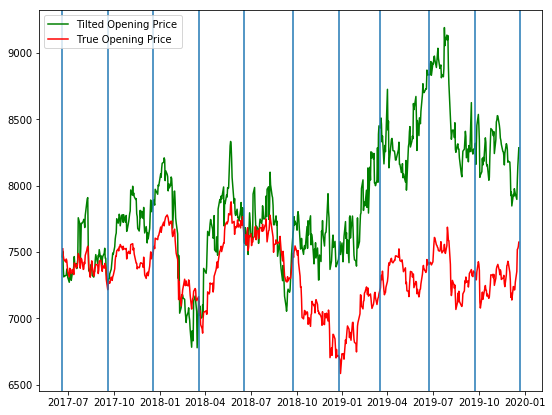

In [57]:
FTSEq317 = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(tiltedFTSE.index.values,tiltedFTSE['Open'].values,'g', label = 'Tilted Opening Price')
axs.plot(FTSEq317date,FTSEq317,'r', label = 'True Opening Price')
axs.legend()
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)
f.show()


Pearson CC between tilted FTSE and Pl price:  0.17319728077813212
Pearson CC between real FTSE price and Pl price:  0.35506803242085316
Pearson CC between simulated (untilted) FTSE and Pl price:  0.19712841527467906

Tilt MSE 45485997.38708924 
Simulated FTSE MSE 33226522.349319074 
Percentage improvement -36.896654151412875 %

Percentage Change correlation - tilted and pl 0.12466784500346206
Percentage Change correlation - untilted and pl 0.11231818797891009


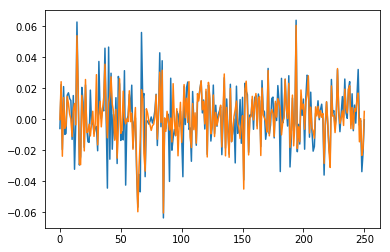

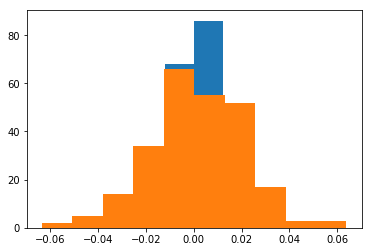

In [58]:
#Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
simulatedFTSE2019=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()) & (simulatedFTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date())]
FTSE2019=FTSE[(FTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()) & (FTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date())]

#Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
#

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE = pearsonr(tiltedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE[0])

#correlation between real FTSE and pl price
correlationFTSE = pearsonr(FTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between real FTSE price and Pl price: ',correlationFTSE[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE = pearsonr(simulatedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between simulated (untilted) FTSE and Pl price: ',correlationSimFTSE[0])

#will only use simulated untilted FTSE price from now on

#Find mean squared error between pl price and tilted/simulated FTSE
mseTilt = mean_squared_error(plPrice19['Price'].values,tiltedFTSE2019['Open'].values)
mseSimu = mean_squared_error(plPrice19['Price'].values,simulatedFTSE2019['Open'].values)
print('\nTilt MSE',mseTilt,'\nSimulated FTSE MSE' ,mseSimu, '\nPercentage improvement',(1-mseTilt/mseSimu)*100,'%' )

#find daily percentage changes for tilted FTSE , untilted simulated and pl price
percentageChangeTilted = ((tiltedFTSE2019['Open'].shift(-1) / tiltedFTSE2019['Open']) - 1).reset_index()
percentageChangeSimuFTSE = ((simulatedFTSE2019['Open'].shift(-1) / simulatedFTSE2019['Open']) - 1).reset_index()
percentageChangePl = ((plPrice19['Price'].shift(-1) /  plPrice19['Price']) - 1).reset_index()

#find the difference in daily percentage change between pl price and both Tilted FTSE and simulated untilted FTSE
PCDiffTilt = (percentageChangePl['Price'][:-1] - percentageChangeTilted['Open'][:-1])
PCDiffSim = (percentageChangePl['Price'][:-1] - percentageChangeSimuFTSE['Open'][:-1])

#find corrleation between daily percentage changes for pl price and tilted FTSE
print('\nPercentage Change correlation - tilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeTilted['Open'][:-1])[0])
print('Percentage Change correlation - untilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeSimuFTSE['Open'][:-1])[0])

#plot of the daily percentage change difference between [pl and tilted] and [pl and untilted] 
plt.figure(1)
plt.plot(PCDiffTilt.index.values, PCDiffTilt)
plt.plot(PCDiffSim.index.values, PCDiffSim)

#histogram of daily percentage change difference
plt.figure(2)
plt.hist(PCDiffSim)
plt.hist(PCDiffTilt)
plt.show()


# moving average stuff
#movingAveragePCPl = percentageChangePl.rolling(5, min_periods=1).mean()
#movingAveragePCTilt = percentageChangeTilted.rolling(5, min_periods=1).mean()
#print(pearsonr(simulatedFTSE2019['Open'].values,FTSE2019['Open'].values))
#print('MA correlation', pearsonr(movingAveragePCPl,movingAveragePCTilt))

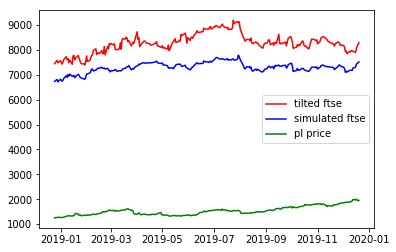

In [59]:
#plot of absolute tilted, untilted and pl price values
plt.plot(tiltedFTSE2019.index.values,tiltedFTSE2019['Open'].values, 'r-' ,label = 'tilted ftse' )
plt.plot(simulatedFTSE2019['Date'].values,simulatedFTSE2019['Open'].values, 'b-' ,label = 'simulated ftse')
plt.plot(plPrice19['Date'].values,plPrice19['Price'].values, 'g-' ,label = 'pl price')
plt.legend()
plt.show()

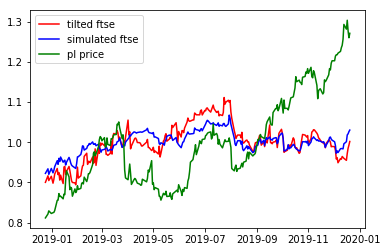

<Figure size 432x288 with 0 Axes>

In [60]:
#plot of normalised tilted, untilted and pl price values
plt.plot(tiltedFTSE2019.index.values,tiltedFTSE2019['Open'].divide(tiltedFTSE2019['Open'].mean()).values, 'r-' ,label = 'tilted ftse' )
plt.plot(simulatedFTSE2019['Date'].values,simulatedFTSE2019['Open'].divide(simulatedFTSE2019['Open'].mean()), 'b-' ,label = 'simulated ftse')
plt.plot(plPrice19['Date'].values,plPrice19['Price'].divide(plPrice19['Price'].mean()), 'g-' ,label = 'pl price')
plt.legend()
plt.show()
plt.savefig('groupTrad.png', bbox_inches='tight')

In [61]:
#Get only 2018 FTSE values for tilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2018 = tiltedFTSE[(tiltedFTSE.index > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (tiltedFTSE.index < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
simulatedFTSE2018=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (simulatedFTSE['Date'] < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
FTSE2018=FTSE[(FTSE['Date'] < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (FTSE['Date'] > datetime.strptime('Dec 16, 2017', '%b %d, %Y'))]

#get pl price for 2018
plPrice2018 = plPrice[(plPrice.Date < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (plPrice.Date > datetime.strptime('Dec 16, 2017','%b %d, %Y'))]

#--------using FTSE tilted using weights trained on 2019---------

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE2018 = pearsonr(tiltedFTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE2018[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE2018 = pearsonr(simulatedFTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between simulated (untilted) FTSE price and Pl price: ',correlationSimFTSE2018[0])

#correlation between real FTSE and pl price
correlationFTSE2018 = pearsonr(FTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between real FTSE and Pl price: ',correlationFTSE2018[0])




Pearson CC between tilted FTSE and Pl price:  0.014726873680258667
Pearson CC between simulated (untilted) FTSE price and Pl price:  -0.5305275937035296
Pearson CC between real FTSE and Pl price:  -0.5472277825446668


In [51]:
#Modified Dartboard for my categories
dart_coef=[]
for i in range(1000):
    tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
    minePd = np.random.uniform(-2,2,1)[0]
    mineOth =np.random.uniform(-2,2,1)[0]
    autoRel = np.random.uniform(-2,2,1)[0]
    autoCar = np.random.uniform(-2,2,1)[0]
    defenceInd = np.random.uniform(-2,2,1)[0]
    finSec =  np.random.uniform(-2,2,1)[0]
    jMat = np.random.uniform(-2,2,1)[0]
    noInt = np.random.uniform(-2,2,1)[0]
    catTilts = [minePd,mineOth,autoRel,autoCar
                ,defenceInd,finSec,jMat,noInt]
    tiltedFTSE = jackTilt(catTilts,tiltWeights)

    #Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
    tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
    
    #Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
    #
    tiltedFTSE2018 = tiltedFTSE[(tiltedFTSE.index > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (tiltedFTSE.index < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
    #get pl price for 2018
    plPrice2018 = plPrice[(plPrice.Date < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (plPrice.Date > datetime.strptime('Dec 16, 2017','%b %d, %Y'))]

    #find correlation between tilted FTSE and palladium price
    correlationTiltedFTSE = pearsonr(tiltedFTSE2019['Open'].values,plPrice19['Price'].values)
    
    # add correlation to sample list
    dart_coef.append(correlationTiltedFTSE[0])
print(dart_coef)

[0.20136321400779705, 0.1378988810547739, 0.19957370920303494, -0.013604125699652312, -0.2817760435299484, 0.15068272255025128, 0.3508969671400992, -0.7843230374527005, 0.2676933167715394, -0.8013691646841152, -0.7202415588783293, 0.05151180392490537, -0.1531868510626149, -0.40861524958815143, -0.07337059767729975, 0.1737517723286649, 0.08765698460041155, -0.13626580934007204, 0.20541357421619577, 0.20294452506310443, 0.1456382643053369, 0.21148355573066344, 0.2380277581874155, -0.4087117492277156, -0.2977332799318954, 0.028408320733865455, 0.20824156881894415, 0.1951351345450183, 0.2109431715465018, 0.17042950887490468, 0.1418142073523035, 0.27228007067803767, 0.20921155985228373, -0.09514481116093168, -0.3526735738575413, -0.04289332915731742, 0.19688527878919238, 0.09069829563975663, -0.40454831228697663, -0.2115666470937598, 0.19084017957554414, -0.08303103654635653, 0.19881106808241591, 0.15415527854060176, -0.14971890549592226, 0.10589683543508975, 0.19462942380694456, 0.21212163

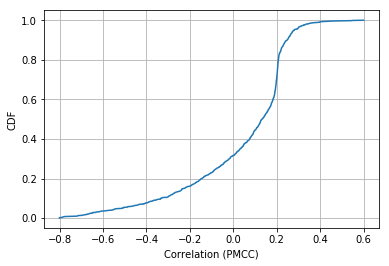

In [63]:
# generated from the above code
dart_coef_2019=[0.20136321400779705, 0.1378988810547739, 0.19957370920303494, -0.013604125699652312, -0.2817760435299484, 0.15068272255025128, 0.3508969671400992, -0.7843230374527005, 0.2676933167715394, -0.8013691646841152, -0.7202415588783293, 0.05151180392490537, -0.1531868510626149, -0.40861524958815143, -0.07337059767729975, 0.1737517723286649, 0.08765698460041155, -0.13626580934007204, 0.20541357421619577, 0.20294452506310443, 0.1456382643053369, 0.21148355573066344, 0.2380277581874155, -0.4087117492277156, -0.2977332799318954, 0.028408320733865455, 0.20824156881894415, 0.1951351345450183, 0.2109431715465018, 0.17042950887490468, 0.1418142073523035, 0.27228007067803767, 0.20921155985228373, -0.09514481116093168, -0.3526735738575413, -0.04289332915731742, 0.19688527878919238, 0.09069829563975663, -0.40454831228697663, -0.2115666470937598, 0.19084017957554414, -0.08303103654635653, 0.19881106808241591, 0.15415527854060176, -0.14971890549592226, 0.10589683543508975, 0.19462942380694456, 0.2121216337944169, 0.12262840317334353, 0.23151834552498654, 0.1797516950841982, 0.029515194212916537, 0.20609371337582344, 0.2970311253782834, -0.6090255296336926, 0.23853996393145072, 0.26941712549928254, 0.16531352882813663, 0.1368540891325257, -0.01260014267857151, -0.29104119621947977, 0.056451968790009986, -0.13570068851525594, 0.02823187944904272, 0.0639365070636842, 0.21013361693135804, 0.20081623365325074, 0.3334600570828022, 0.19058929887052647, -0.1960138828006484, -0.030418368473087796, 0.27269022710513774, 0.008216063924865541, 0.10884185484636807, -0.15895077598041482, 0.14603857181581112, 0.2550448337605673, 0.4986858824019999, 0.20277867282859252, 0.19403099934886495, 0.2011676372981487, 0.1686320965857399, 0.3050251074289153, 0.07483730738942075, -0.06239471852877584, 0.20511006938538318, 0.20448507230237656, 0.010713621408652283, -0.5464372083502967, 0.20958135230849015, -0.020582966524560452, -0.2664635749124515, 0.20596819100959496, 0.20176310953385596, -0.0220525002622609, -0.3058433628552634, 0.12827440954225497, -0.2375102604527757, -0.016805644195110072, -0.05584173529929345, -0.6479905384995879, -0.6622096006278373, 0.19383364534178318, 0.26596587955642936, -0.788342934571048, 0.08201020677582305, 0.2688794933678656, 0.26981849034538635, 0.08336834402774916, 0.19755475415856913, 0.16214747117626988, 0.21725060733393792, -0.19146131381874196, -0.2381692118086918, 0.20086853752900846, 0.27190490069335865, 0.1907391333130075, 0.2388807802208683, 0.1579665254247497, -0.01918385278137084, 0.20095755283704544, -0.27040389099972945, -0.05878733865945197, 0.24113976774227433, 0.12029151129402003, -0.06503555635170441, -0.24120125426812658, 0.1899876956437806, -0.21533079731312363, 0.15983643650889628, 0.20370826203770237, 0.19487466120582617, 0.16756798819363913, 0.09409678027646401, 0.2510275223270609, 0.1762136539906198, 0.159177320692138, -0.6123413626309209, 0.20119594927404863, -0.14346650321373838, 0.10641051648475633, -0.38197557705322077, 0.20466742249439276, 0.0015444132148621748, 0.0866855380193476, 0.1863102608278071, 0.04617889508184593, -0.7121615096413593, 0.048147604011275824, -0.2882296252977833, -0.21942800522040243, 0.39872408430071443, 0.20070869064631006, 0.19427416645939496, 0.042020765480465606, 0.07154037933066057, 0.2645134193720662, 0.036252896843074554, 0.3021180716008329, 0.19118596655754996, 0.1134647674597707, -0.10823707795270877, 0.12618981545409041, 0.22685912462083832, 0.2196228258053954, 0.38849239227238225, 0.22163126499708297, 0.22464923505078668, -0.696173695889045, -0.5952929843665412, 0.21857981493180598, 0.1971284152746786, -0.037790738774355064, 0.13881481133000925, 0.17790632982326315, -0.2711855210364934, -0.6612767239335743, -0.09012159276542275, 0.20057774663692574, -0.32512254441777894, 0.012160095196840592, -0.17026481651788963, 0.1174417463107103, 0.01392930091924326, -0.3498193951894788, -0.6728058412566096, 0.188319727136606, 0.0065762610801462324, 0.20654080228726535, -0.367081923137282, -0.5065502024428905, 0.19745259803728413, 0.0834250906760088, 0.2031356002394695, -0.45084524440127666, 0.20713394434049803, -0.1276820465884231, 0.1833155293767815, 0.3975706965707132, 0.13986182704288164, 0.09465956203038425, 0.20479266593324175, 0.15538683170266882, 0.23026879176109888, -0.1056860207283234, 0.031139459493542847, 0.17286952508595177, -0.2328637585601063, -0.029238780957465578, -0.18528514428980028, -0.08973507955848146, 0.2074392367768283, 0.17386513819689098, 0.2624270611714691, 0.15930055834006746, 0.039466716263749514, 0.20485822415994692, 0.19729570190653317, -0.30317586365287924, 0.04633337427451031, 0.19889251748550454, -0.03499282913074431, -0.013542808911919224, 0.2063830142453476, 0.233183153809606, -0.035419522968659634, -0.10233712523516315, -0.43997660653655507, -0.11793573274366902, 0.10901308709894052, 0.18409474227136166, -0.14731268854974255, -0.6335120577123252, 0.2034606106861934, -0.19552457119983951, -0.4677935093863914, -0.15386275095756588, -0.22138355584770528, -0.2473430702172212, 0.36421524649967185, -0.4585398385904156, 0.2096347187943224, 0.2004386505849625, -0.40539887268829866, 0.21594295507250832, 0.18168726829526283, 0.05017131240657834, 0.2543355684669558, 0.1924434048714924, 0.19905477014097556, -0.4354372788988055, -0.04690533869375862, 0.3171003845646675, 0.21191042816018332, -0.18343696402693382, 0.20760549598950864, -0.6185976375532508, 0.12551863066299332, -0.13098888948081042, -0.023161490309661588, 0.19055655715118833, 0.17113120494482162, 0.19111528169264236, 0.23318127539115865, 0.2017652554269569, 0.07457052141230505, -0.506326465367352, 0.2991596573539121, 0.04085086555030742, 0.08116218420989783, -0.1785765138944482, -0.04339657855516761, 0.06265399802683252, 0.067061371872023, 0.07826084615569506, 0.18865051347181003, 0.03984586951463012, 0.19097988536193192, -0.1767890857323042, -0.09225218538082082, 0.1998844736492864, -0.2748966268151138, 0.20195520689836283, 0.2344548065063827, -0.3350091963719155, 0.11815470951004181, 0.014161253702749298, -0.29578442653857323, 0.11834868827963524, 0.05396424005493899, 0.023682204263901177, 0.27521184445280994, -0.2633278412599463, -0.01830842801946126, 0.1819037939392192, 0.2096231636050525, -0.2026180120403404, 0.331309948097929, 0.23873837371585924, -0.2513835974309394, 0.0476773758373277, 0.021269148095545507, 0.12228832727975766, -0.0035554890563798307, 0.07228922607995451, 0.09257127484303396, 0.18701974515077713, 0.060589884401324186, 0.14655366939653214, 0.21234185877547015, 0.2288728085006513, 0.13095042322658668, 0.015001345263054956, 0.20708247848118874, 0.19432224339621246, 0.20256841344078128, -0.04979812756907076, 0.1538789347043674, -0.1353232777902125, 0.14771143805530512, 0.0638442179486429, -0.016041992759532622, 0.1811058204464584, 0.09247575053059284, 0.22026022088900474, 0.20877738019623376, 0.09268450707980071, 0.1766973276812151, 0.25213929092293447, -0.3936906212093402, 0.3456632265023595, -0.54925955903868, 0.1831582742765042, 0.03436149304952667, 0.1794906855049019, -0.07165433300208839, 0.12811319387383824, 0.2977745196624448, -0.012781533162915594, 0.20284563208855652, 0.13692754304145255, 0.11832521344655308, 0.10711936982442302, -0.22672513884514536, 0.02038423477073125, 0.20135935072141117, 0.0953025750675089, 0.1196460563056573, 0.08970594616785246, 0.19718312287620476, 0.011901345945137568, 0.15276611675925916, 0.17699656480418668, 0.044645006970881106, 0.073827455183288, 0.2204863171316519, 0.1903085100175044, 0.14933985287322235, 0.03167785514174258, 0.09080734582344833, 0.19615765824120118, -0.217714900552237, 0.12306150939567519, 0.1338300737478296, 0.33855770573839306, -0.21485874817490785, 0.2005881419435234, -0.04302129566116378, 0.3326595887804295, -0.4005112601080027, -0.18887534263521444, -0.27592629722067635, -0.09387022251038887, 0.17525351499521544, 0.1809936324915048, -0.002158571552719643, -0.1357788020880318, 0.20770146298024134, 0.19779910506580975, 0.08228707654675839, 0.2335810791426165, -0.11266236031192271, -0.16307691625615509, 0.09076917186825416, -0.07729038865367747, 0.18737243166517614, 0.20517580347219022, 0.15546480971465113, -0.09397709185316215, 0.15831032100755843, 0.24840188198149515, 0.08829793298937998, -0.07889863945387929, 0.18939192345261338, 0.20877850418312752, 0.2144019188475977, 0.027183795117815816, 0.2125969817166199, 0.3165313963035658, -0.08844733397724633, -0.6481697892428079, 0.1234473516705248, -0.7880264191364067, 0.17404876277673945, 0.24738506384424366, -0.1729650166943342, 0.21872927697565092, 0.25291264002374847, 0.007871211125755832, 0.20187376387637582, -0.03980498280713211, -0.034442409499881727, 0.16517636898802884, 0.18232399901151194, 0.20151582298329018, -0.371690533923888, 0.1987635645614598, 0.22928197313416596, -0.2359445741716434, -0.05202016858654083, 0.25680490259439837, 0.19204511353707063, 0.20481369165506533, 0.22053788830235518, 0.09164313258076456, 0.19250684255864456, 0.20159256827299343, -0.5804927753738398, 0.2370939384157269, 0.0870803512075603, 0.29981927889389154, 0.18862956715722135, -0.011243380548408484, 0.18659712962338135, 0.20204239264550686, 0.3101699003731896, 0.20255325708816987, 0.21243179745486904, 0.03817740600659121, 0.19861926116484407, 0.1962091193925268, -0.457149475813795, 0.23176414892883426, 0.2086249539042819, 0.1719134929958261, 0.16420848017666922, -0.23884086708079494, 0.11439556972025143, -0.23779424141673713, 0.1974186894810435, 0.19713428506301756, 0.271519540423108, 0.4254985560076308, 0.20261922013780692, -0.15458694593684089, -0.5067798069947013, 0.20055196322520014, -0.1949433906989767, 0.12289014918425661, 0.1704620841571128, 0.029926483254103527, 0.2047499814084441, -0.03986393983139242, 0.10331229899235027, 0.19363814091958007, -0.05012902409289794, 0.2945521352607417, -0.35634596020989845, 0.14679274958315722, 0.1123502742169973, 0.027963863754002515, 0.10358357894138533, 0.2156790787210231, 0.19492450054136634, 0.2014669746156111, 0.1972909487104845, 0.19814712101181237, 0.09822709604206761, 0.07802882825359046, 0.22406378236122504, -0.15819553228148375, 0.07499376184676328, 0.31059388464577575, 0.1960537739421298, 0.12507021866177895, -0.06757555721590594, 0.19822733786585334, 0.18204699075375214, 0.14809543861583793, 0.15778439689480875, 0.09772410818806788, -0.15999188168296133, -0.27899129025597613, 0.18618288741430516, -0.6634263239564241, 0.3769834133810515, 0.17106332307273336, 0.06306144607440262, 0.2512954872906055, 0.2935200853163916, 0.26117220626018256, 0.015133801012226332, -0.11393830439959222, 0.185301080136642, -0.17403755882238361, 0.3240812197842427, -0.6724487715854129, 0.19346461729221814, -0.41365727311384365, 0.11314776440395581, 0.20470490177407216, -0.6482638738581694, 0.19015690918542558, 0.06858192179621413, 0.2548484777046832, 0.36363351368461594, 0.21818822502209614, -0.12395804912270757, -0.2898645917489759, -0.47240097506618306, 0.2805615400844395, 0.28048369529440503, 0.09699879902058818, -0.6654847637857634, 0.19568584453547477, 0.20302610212606695, 0.2699850310153511, -0.014162984167163734, -0.29753642990493345, 0.19849149533017288, -0.3556023194360446, -0.24256763835296566, 0.061796341622160175, 0.205565512795969, 0.04774576285373799, 0.244599491723117, -0.157294728693631, 0.1484436826795246, -0.22264794983825895, 0.034657640968286746, -0.32847107376165363, 0.006340140479424761, -0.11559458690860569, 0.06257224440986775, 0.24914079542298295, 0.20562665734645366, 0.12282098439714427, -0.2988018467098154, -0.277550920156076, 0.32402973086605813, -0.28884636829311805, 0.12247164253570604, -0.33051141028735254, 0.23366967774219854, -0.38050606323478425, -0.17039309512416578, 0.07159324646928603, -0.63208529718377, -0.14536764315998577, 0.1718141458000518, 0.20738530986126633, 0.3058237152763204, 0.05681108539716806, 0.26924079799821604, 0.20196436586381852, 0.26152762614867897, 0.20624985090710665, 0.21528883964337095, 0.07882993969130353, 0.09337141084153573, 0.12098617043305575, 0.35385812654998183, 0.20202521444128851, 0.20083696869423945, 0.2201182675985373, 0.11692464818087955, -0.12750714006572766, 0.2188454149835982, 0.159359442744907, 0.07716419644223231, -0.1987410417159625, -0.28180346123957684, -0.10651509513458189, 0.20619532001705312, 0.14120304022395405, -0.2233282526411738, -0.029447102075791987, 0.2354443246672489, 0.19566149667593036, -0.0903905760987279, 0.19341348826783653, 0.2103030874871769, 0.111508947425707, 0.2758927939337388, -0.5150614880239166, 0.17192330817000706, -0.046714510974653664, 0.2190931733558453, 0.22204303728811325, 0.27904463806738, 0.19465280646500743, 0.19550052862306708, -0.045120822391262534, 0.207386405614676, 0.09584615353390011, 0.21110418334677583, -0.3343487584149354, 0.17260891143632215, 0.19836859071257046, 0.09811369537047132, 0.19712841527468927, 0.19935930154919562, 0.3984770208373627, 0.19412933648774466, -0.39130172869343527, -0.061976225156538625, 0.21015922344351845, 0.19019077292504988, 0.20627029962533577, 0.20158136645795402, 0.20837070433330176, -0.02695494190201807, 0.1748311124736735, 0.08063792096294206, 0.01841418190273727, 0.04999364577941549, 0.2971499302361024, 0.26300654087055836, -0.09215454508548965, -0.13836484914465996, 0.0035365617137779757, 0.11451363252205177, 0.2212633846769476, 0.19712841527468764, 0.20780626022604654, 0.2503479646686416, -0.023538203703695634, 0.22565443939816274, 0.20303646659756294, 0.19693680160972574, -0.5523070451312349, -0.3868993763672836, 0.45411441812561976, 0.22223875465033338, 0.10600422938701527, 0.18452657723180588, -0.5473628029070541, -0.2844441881522003, -0.09777456684937853, 0.17391494847461386, 0.2593711038829462, 0.1430535094284558, 0.19222977419896567, 0.19221333079082215, 0.12443527123665706, -0.0848849641358963, -0.11358556637530397, 0.08446211549756862, 0.12235923817090807, 0.12955420946700374, 0.25955144416388004, 0.17380522813453045, 0.17053176544731627, -0.025740272023009537, 0.2263052084629601, 0.2835144042818544, -0.07675132802568743, -0.022428819549327902, 0.19912275547463174, 0.16624847183701189, -0.235865175536351, -0.18053669475902392, 0.10534591211781709, 0.27911733812781025, -0.06894212923062214, 0.20215253273749256, 0.19388453448702597, -0.1568706178578465, 0.32169125956926803, -0.2997179192104103, 0.20276173305568, 0.18190487783193224, -0.49224714144883847, 0.29895031851000226, 0.2638949821334514, -0.335118992466125, 0.23002565408896505, -0.29218950144187267, 0.23193216883147885, 0.24326393032635568, -0.23967117578748667, 0.2742176296678045, -0.08438647719412679, 0.14309517730858337, 0.046684774864701364, 0.173921899071525, 0.18652748609753167, 0.24106802016826168, 0.19116928049441173, 0.22328867402961625, 0.10120762887278864, 0.14181382236637569, -0.058213447388207204, 0.22357867339763482, 0.07545314676669176, 0.16506375045757013, 0.24794350147653718, 0.20498767093165526, 0.20245199123129212, -0.23806714099131046, 0.2031784800026732, 0.32918865698614913, -0.2062028119407313, 0.1881827937086604, 0.2090025063091114, -0.16755755001421094, 0.20838490997103684, 0.2005840133489635, 0.19133124159156623, -0.15109879135300083, -0.14064225808521308, 0.4547943534012855, -0.5353055757698831, 0.2077076683926324, -0.03345278261070634, -0.7169787882399253, 0.20129959145371273, 0.20607711763976186, 0.5440737833528237, -0.3730952681056101, -0.43126989296187884, -0.1417345793718641, 0.09570593455869203, 0.23835163130414397, 0.255271060897501, 0.11527293939555566, -0.3346866451486624, 0.11469108180878136, 0.16633484677858565, 0.20481702152536496, 0.2717696345590742, 0.15565298805355823, 0.2679166837472508, -0.12694091885886366, 0.22940311541645753, -0.30125443479103264, 0.12629327166642235, 0.2027928972937125, -0.33539622447904577, 0.015927015787489306, 0.09068631026533687, 0.20022420018159884, 0.14848298883846486, -0.3468195532390991, 0.1351664795104839, 0.2416002376115214, -0.040724872431246964, 0.027808000059494187, 0.25559667916025935, 0.20166162323879627, -0.058505197463187934, -0.389065278828239, 0.18943499870136374, 0.2642219760208556, 0.1328490312908996, -0.14300114125581617, -0.5876085981182686, -0.6496370183847398, -0.5072075617301832, 0.09272218276291225, 0.08602960923864428, 0.203646100727378, -0.17509456731744352, 0.18713954740724142, -0.16470187639585893, 0.14232301126467797, -0.3706245999833649, 0.26129706543386166, -0.05845859642166945, 0.20701227614256437, 0.11129186115589783, -0.2196858116060024, 0.20658228069994608, 0.1514096696666435, 0.20778784653596444, 0.19712841527467306, -0.046429903395804044, -0.7818908939583631, 0.12455711648622579, 0.1046119477386983, -0.24337311376435644, 0.12058534622486351, 0.07341949507520634, 0.17637916965205064, -0.06512935143586339, 0.2112229590672856, 0.01817724172803535, -0.18151464447331128, -0.739239978162208, -0.08654181247473487, 0.07454847957385033, -0.014208293829593904, 0.024884192948129165, 0.1661624529401549, 0.22666141851406002, 0.22055396525059784, 0.18139377071389323, 0.04442704832891988, 0.11593723201847585, 0.20718687777861092, -0.08634799624972792, -0.05976861202523596, 0.20593647449609317, 0.1404421920053926, -0.6785599148910998, 0.40576437123667486, 0.19579872688153382, 0.20128213219004593, -0.2609891350668815, 0.26111030689167103, 0.09286312401748133, 0.20733733994260364, 0.22230864713039702, -0.4858265009578573, -0.7757310762573493, 0.2042945226088595, 0.18684713948683176, 0.19560284240614229, -0.3921997347899205, 0.23514882858357766, 0.12568711463148136, 0.2561161669248316, 0.20434920358944228, -0.04485577412756523, 0.14342049836430135, 0.10217762086385315, 0.18786420485675853, 0.19412109621161547, -0.09946644360687185, -0.26944226889197026, 0.12496301137124191, -0.4866415339834993, 0.14722352350019485, -0.009049683584293524, -0.26894616124815857, 0.1333433494737155, -0.4609492393564969, 0.20124500777695792, 0.0258125315483533, 0.19381623644409401, -0.052689500597140504, -0.6825611219767678, 0.1390702684317467, -0.39358372546223164, 0.19807290942071987, -0.10964596478293226, 0.04614955625168456, -0.5590029154537982, 0.2995662069221176, 0.20136664137490815, 0.5998219169317166, 0.05477746404976365, -0.7903916824055023, -0.4138314446855986, -0.13560669701631842, -0.19310029044201157, -0.01442618458206312, 0.2627856344629895, 0.20033954279861527, 0.19686877134335878, -0.0974193677862108, 0.15614476207235037, -0.48730594717751935, -0.5508971463975181, -0.32878399738120695, 0.30067251100688375, -0.7162226066309413, 0.03639183544603679, 0.2012472173286104, 0.12930459975385677, -0.36688882418422164, 0.19411258666590742, 0.21902118789244251, -0.27813457616822873, -0.1337815042163407, 0.1989242178011831, 0.21845929037751108, 0.29327157960949457, -0.07850950541313235, 0.19637892123172593, 0.07827829936580565, -0.577827520895732, 0.015443231949956513, 0.18208459236608718, 0.19184253205565044, -0.2541209625206089, 0.041967931021690566, -0.11926981798993894, 0.2582905616396744, 0.2041685345108294, -0.438182531268526, 0.20872837660693588, 0.07841607405502535, 0.17908066321681557, -0.2582303603672222, -0.5429199525790143, 0.21526137162882997, 0.07797302466730044, 0.1939572254515605, -0.0035489365111655677, -0.512423821081818, 0.1934373786325143, 0.19474554281643813, -0.6148257837678063, 0.22876692590084147, 0.18644454213527503, 0.18067794344674898, 0.12764870761669733, -0.18793408404074868, 0.19715227629836515, 0.28159693167744804, 0.006015985287387464, -0.0044115759174267796, 0.19958441726923423, 0.17589532216172926, 0.08275644888465564, -0.15180048959773212, -0.44767392253976207, 0.19117651208457948, -0.04257134275834105, -0.008482156083241219, -0.16092217712803356, 0.18991951803985768, 0.06568590051961018, -0.06968569042818758, 0.19704491123761622, -0.6938445375525953, 0.20241525320244763, 0.21753031416931276, 0.08921296248061793, 0.0473261955522776, -0.1731390442650465, 0.23248077345434354, 0.2631656080558776, 0.16208363087158892, -0.08967082078229145, -0.15276356797448518, 0.007231352310022056, 0.2064564251953143, 0.162878478120713, 0.10523965698496171, -0.43524637958620016, 0.04057015365917508, 0.04995293572125755, -0.24462899660057943, 0.20920581881287367, 0.2007757623609879, 0.15303316497333272, 0.16424458182086046, 0.021274176363623134, 0.13374736095497672, 0.16038428467494686, -0.5617737678266959, 0.2802800492102423, 0.04412012215504612, 0.176552435610991, 0.00748388030391794, 0.06239027298049902, 0.31347830934091203, 0.2521940761805167, 0.3453727037240545, 0.17901977701446178, 0.21520046266847118, 0.19936764724215825, 0.5468795093966272, 0.19509804786111204, 0.2100528898996316, 0.15770087140259054, 0.19982901809663428, -0.10588726802486134, -0.8006446750739644, -0.08120178984831564, 0.18334418211428913, 0.19097544530732108, -0.10809605778385392, -0.6294809760380511, 0.23908291871416248, 0.17460895234534926, 0.20496009770737514, 0.20430631990603118, 0.2051439451746319, -0.19170555780934018, 0.2507393547746475, 0.20403827758320509, 0.20485138537677655, 0.2535956402636766, 0.18460621465956684, 0.10389147178874154, -0.6885069957773421, 0.1665118533789619]
dart_coef_2018=[-0.41181620159771004, -0.5381245204276403, -0.36791123411958887, -0.10866950722681813, -0.2091301928612366, -0.5515149938770764, -0.5244693395246391, 0.12651403615522877, -0.5286083558384533, -0.513549597792388, -0.5305380999209075, -0.475932482435153, -0.5030663251091433, -0.2625590832937977, -0.520918010930192, -0.4291770572195583, -0.5043908834660402, -0.5255248719266238, -0.5247746186221404, -0.510406419578859, -0.5409149844447808, 0.037760680577774416, -0.5067828977088364, 0.16384441157692795, -0.502911683603556, -0.474421963394307, -0.525876221333097, -0.13310793690684886, 0.1283178068232067, 0.012351517111421951, -0.4579806245139913, -0.3239085408546018, -0.506260194181809, -0.041723069674198476, -0.5091533426032475, -0.5261593797966129, 0.0028555912001389694, -0.5162967333557102, -0.3699857764778564, -0.2519699663407854, -0.49166662031230224, -0.4846302941605936, -0.5275280684975602, -0.5258458773353126, -0.44256056615437606, -0.510611574202455, -0.47013475093172163, 0.5838170968547236, -0.5119587937077401, -0.4275956382153306, -0.523060176895039, -0.16347919248079112, -0.5282074283506368, -0.5102127062455081, -0.37401220129983254, -0.5188751805871018, -0.47582237592444804, -0.5195381775074389, -0.5307985246419729, -0.5032175355155769, 0.07457646043280845, -0.43842695576230245, -0.30320332908484876, -0.5025386554696725, -0.5354034482020704, -0.523799042298278, -0.5083229335984565, -0.4097738579393492, -0.5270775565473549, -0.5238677340305039, -0.5107505647819364, -0.515645885691035, -0.1497739978935471, -0.3437675295054304, -0.5025191975353346, -0.5243212448714782, -0.5270082436337387, -0.2897607227706401, 0.3824623977107373, -0.5144342075084147, -0.37083396130437235, -0.39858937701648295, -0.5292007937021521, -0.2183583327309507, -0.276083513063579, -0.18592366828353774, -0.49048242722105057, 0.03250843675837567, 0.602773442556828, -0.46305625881869084, -0.48914303802760806, -0.5286625287311444, -0.5307046808891372, -0.5076705422244944, -0.5013885358373396, -0.42926665306594897, -0.5157084200538279, -0.32809005401211594, -0.5270767972020463, -0.5081254957648631, -0.3979865188003703, -0.5271692468896315, -0.5240997757675708, -0.48604248051301396, -0.2919950978949467, -0.5178165369093763, -0.08724481961807216, -0.5245883089125373, -0.5080653689067576, -0.5011241920729456, -0.5361895389917829, -0.4849881134807088, -0.373463801161012, -0.271173057021999, -0.4881898605288765, -0.5194526727511689, -0.5295139106525022, -0.4939025157625837, -0.5268153769233576, -0.31482012305901363, -0.3564978479684845, -0.5188356185504036, -0.49784194794423436, -0.26690681081279843, -0.5289952487757695, -0.5325065474212207, -0.4823961246806971, -0.5049751275646275, -0.5163208632007859, -0.22085003242611578, -0.4663021194265991, -0.5127291411629249, -0.5143215039477838, -0.4264874502897394, -0.5200551524619741, -0.5307632611869472, -0.3957230358316741, -0.3949748578254016, -0.2849561183363089, -0.4808416739096668, -0.5237842094678219, -0.5077847464885843, -0.37477454424907947, -0.2816081970772947, -0.4933465355114306, -0.2830155629897139, -0.5293221121195963, -0.4910698555884257, -0.49176010622748306, -0.20166563815744173, -0.5558700945958277, -0.5311853415548317, -0.316107435877852, -0.538645302607175, -0.5138845539898985, -0.5177948392511128, -0.5266560927563211, -0.4289049020577623, -0.5146673207696628, -0.4894520371258895, -0.3543320089459856, -0.4550872294988685, -0.5285401634328715, -0.5251299657011526, -0.17845610907217718, 0.19013046895793728, -0.4975889513692416, -0.35837329353320596, -0.5321689832982472, -0.4825120729341594, -0.5547234816674559, -0.5245710569093305, -0.4625332948192753, -0.5079364825566676, -0.5029591922035614, -0.5077295408262079, -0.4261563171633658, 0.6431849927527761, 0.07154790333085372, -0.5003976748180768, -0.48489404818991927, -0.4421293017848379, 0.46659614368869073, -0.5333469601324204, -0.12835410260340085, -0.45392650311221594, -0.5232736428909872, -0.5393282040924328, -0.24895632914294782, -0.5042562755918799, -0.4608913635524008, -0.4293427967307192, -0.4851946553432957, -0.3415135196149952, -0.4515627963477469, -0.4726522200323252, -0.33762097323565504, -0.12976090480611224, -0.49818299608748157, -0.5111015007578239, -0.5380829484585444, -0.4197059110062327, -0.4909679171057987, 0.31074719703112563, -0.5006422607447031, -0.5265788469161092, -0.5193899790834686, -0.5294425515014456, -0.5123918104346693, -0.2763140025367279, -0.5137225716717964, -0.5207719761737944, -0.5285294258660955, -0.5264868258173067, -0.5329281041150883, -0.47172967837637275, -0.34740620759774005, 0.1510195568072709, -0.5126856316479034, -0.5215973602434256, 0.3759624422014015, -0.4626149271002569, -0.5307115568817528, -0.4198054650410827, -0.5489036351937648, -0.5110750030566803, -0.1507570328632768, -0.3101868879776505, -0.5304793668573231, 0.41487530872211303, -0.2906567010560745, -0.009811251943944364, -0.5280426462016503, -0.5117355287536941, -0.5146785416986488, -0.5269015239467875, -0.09035349905854825, -0.5240217377723196, -0.47800877391914204, -0.5184095019835724, -0.5283317092055443, -0.38522319308903036, -0.2244232828509262, -0.5131285833802522, -0.463394732968639, -0.38457276569525384, -0.22317386154054222, -0.45195126675037445, -0.5280496814242477, -0.5918780820233439, -0.5225440959311344, -0.5273326800066443, -0.4889241441578663, -0.46430371757829275, -0.5107961135639811, -0.5097408607469486, -0.5190576613590775, -0.5142134491947888, -0.5406348360721013, -0.5289440399810551, -0.5077301325673427, -0.5510766309354107, -0.4809737407322583, -0.4452616302290857, -0.5290014696541898, -0.20569353621689618, -0.5224045921407859, -0.3066226194649461, -0.49858927520848817, -0.3403559013276123, 0.568507633811964, -0.5165396964864825, -0.5127595410171832, 0.6078565344576506, 0.12935401888781578, -0.33387600877237006, -0.40301175928535066, -0.5085062667398125, -0.4957210076027728, -0.5115608818620009, -0.4643697988692288, -0.313638166272308, -0.4717426930590134, -0.5042813775247735, -0.46708927927831806, -0.2605357809065498, -0.5224566938744745, -0.22821184033089453, -0.488537904181646, -0.49474033240244114, -0.28198265757762636, -0.3473665416802402, -0.4639620823333052, -0.5128232864147514, -0.5094110532161323, -0.06985817058861145, -0.5235325347236387, -0.17019181254704152, -0.5261843111354347, -0.413425735791884, -0.5119235422603423, -0.07885478423043826, -0.5286008923569141, -0.500142090043446, -0.26383610767995513, 0.31055784253955365, -0.3107355463724095, -0.3497742704658697, -0.5409332267611499, -0.5585569991596272, -0.5305275937035256, -0.3916878863395643, -0.5107630436285283, -0.23526725410395685, -0.47002298619070104, -0.527773515767683, -0.3716186672845352, -0.47538751583558986, 0.03895482116064482, -0.5096464075865195, -0.41262424775044515, -0.43612114009307335, -0.3978215726482522, -0.4651780353676749, -0.3122930408481538, -0.4853994555745229, -0.4140346727769072, -0.42995065783821584, -0.5270712304683268, -0.5218486535320875, -0.2308711318214057, -0.42374719200663924, -0.5249682855379905, -0.5310477093969685, -0.502202202009493, -0.47707187652094, -0.5279417147328792, -0.5132953441223891, -0.5161333880663725, -0.523324823901611, -0.5272551497157312, -0.5621053899863139, -0.24790372132809793, -0.5087694798547958, -0.25624693984627234, 0.3083458223422836, -0.39879912277374546, -0.2650557024471378, -0.49855498555438277, -0.3838614611689029, -0.5274624191992583, -0.4440698350871101, -0.5270839725372094, -0.30449212669298237, -0.5258920370125941, -0.3851313753432557, -0.5146657193333088, -0.5501548166036717, -0.5032787855169281, -0.10155564578935274, -0.5173418994834056, -0.2418096799745216, -0.41960115796748076, -0.41341119905184, -0.4915677656979209, -0.4880026099171851, -0.319776524124291, -0.5050690566509785, -0.5010545177296342, -0.5138141408655164, -0.35351597649228256, -0.4884189567279422, 0.3052218951337326, -0.5169390579894673, -0.5104647835277254, -0.526554351453981, -0.5054591231171546, -0.3377793893563788, -0.16389893549857365, -0.5042416605224568, -0.5232413041543277, -0.5120366296987041, -0.5310312733031456, -0.4989178797868748, -0.46304051017733433, -0.5076476031464678, -0.5257507550803097, -0.5015862599547324, -0.5291442229970792, -0.5247862968888796, -0.5030303090568822, -0.5307657079479962, -0.495803647673956, -0.49360210401542914, -0.3519304661791739, -0.530455735704711, -0.46767944425952257, -0.42443338666565034, 0.10035341516618823, -0.5534598338905528, -0.5195541787422311, 0.4341382102030428, -0.5311289815826115, -0.5083569739791972, -0.5307661308586475, -0.181401373840261, -0.5293146110099537, -0.5072134983676011, -0.5414581182246523, -0.5078564325519684, 0.0644774541393573, -0.5152392543908216, -0.5404581109895178, -0.07882266661087378, -0.03941600231835764, -0.3380234455033938, -0.1782700816633894, -0.2530044572680936, -0.34816248150895346, -0.5133528462940063, -0.5020672813049076, -0.2637782527853794, -0.14303704333454678, 0.016070812641874224, -0.5268386817547692, -0.48801290729892793, -0.5175455700670427, -0.4598323563205932, -0.5377001392866867, -0.1851230752653313, -0.5068592087458841, -0.5236114357785527, -0.49912483736422036, -0.3608918541989409, -0.5768650885543858, -0.4744844191328892, -0.47666248525242155, -0.4346558128152717, 0.3557608046469613, -0.5123528447999509, -0.4059145559382349, -0.5247753245653276, -0.5281787002884633, -0.5264358033923555, -0.5128781317623244, -0.41382166098536594, -0.48992687838874405, -0.4298724496912748, -0.5252101037145006, -0.5328601867691304, -0.4530947426217268, -0.5308390602502071, -0.49892803850639467, -0.4733441758644508, -0.517800329756234, 0.6408645925770738, -0.5307333391397949, -0.3895961310718243, -0.5107962226884722, -0.49798350004991054, -0.3182806219310398, -0.433139861445583, -0.4895646890935776, -0.5120803328737183, -0.5655340780845688, -0.43341457024109264, -0.5272041661570742, -0.4201441855795614, -0.5245339453346337, -0.24089231889728915, -0.530770517299126, -0.5265797913214355, 0.01775511440973666, -0.5205758215879829, -0.5018308039973706, -0.5050750524056703, -0.5390659338804694, -0.5096952107604847, -0.4553964556426641, -0.5074979041331283, -0.5421459879972432, -0.5148622820355817, -0.5305275937035263, -0.5156860847916034, -0.5315752697147768, -0.3352676008932185, -0.51821304747216, 0.43498181645630235, -0.1199732597618513, -0.5102761544231734, -0.531871198795537, -0.1494665316354839, -0.5193477194857083, -0.46194339943987195, -0.5397192553977608, -0.5446809172758487, -0.5277378195966973, -0.4840803021791485, -0.5123123924323475, 0.29848257878374307, -0.5251001545458368, -0.47141354534963753, -0.5290669050025305, -0.5293447643171054, -0.5305341487248287, -0.08258394079828404, -0.4882538275409546, -0.45500540944398454, -0.4939103599064518, -0.4642440949150397, -0.5095675726880666, -0.5278101813886427, -0.04701518696692405, 0.18263425453926943, -0.4787565906428528, -0.5655185870259815, -0.5275297514125754, -0.498457411894398, -0.5272981524296981, -0.3241974347115424, -0.5091272379015388, -0.5127871248645133, -0.5122832712385542, -0.530527593703527, -0.5226331810058382, -0.5312899204562407, -0.007931656149958754, -0.24520206496973068, -0.5205233393675679, -0.5242877175801327, -0.5219147193803855, -0.5107919860215947, -0.4915840203530627, -0.49270103099971674, -0.2815620957391508, -0.5158738256932974, -0.530527593703527, -0.5192268059095606, -0.3753137632822283, -0.45765190266511735, -0.504499743947519, -0.4024936222675025, -0.5369718533092123, -0.6009730102753899, -0.44786368006098226, -0.3101323810333959, -0.49205080190744516, -0.5136913231030157, -0.5150957472869571, -0.4921778253853599, -0.510717387588339, -0.11956687764478294, -0.5293207037574617, -0.5283695534786539, -0.5202144685711441, -0.47184007172347825, -0.5173969439456663, -0.35772278857996487, -0.5059067141761742, -0.5146229723983972, -0.3926949278832638, -0.45355424397371963, -0.28063519051144553, -0.5086277634236795, -0.4990007359476285, -0.5191173537395808, -0.3847272518649284, -0.4859691465001478, -0.4848975752054851, -0.4609869186478888, -0.5220913286445081, -0.4980456564132236, -0.4915840383444524, -0.4732855646316796, -0.2755120119015414, -0.44309410647152786, -0.5277135702621966, -0.4283353390875001, -0.537298436146604, -0.5305275937035258, -0.46786805661399966, -0.5279266187037346, 0.5543699492768832, -0.5271580420704569, -0.23668956602272642, 0.012832034574294316, -0.5493106230882003, -0.2802514568530433, -0.46321223084401514, -0.5332794248808838, -0.49654766573582965, -0.20276693185580075, -0.49008162786450793, -0.5311781501430559, -0.5077847331949459, -0.12737940981470622, -0.511103290275132, -0.5131756514976588, -0.5024620168314435, -0.5051188807280526, -0.5288064387750376, -0.10514669307529673, -0.5169966170163045, -0.10298879863379834, -0.10405836091932015, 0.1336793853203418, -0.5176055360479389, -0.5275215779795928, -0.2232653214888205, -0.5162971694535377, -0.5158730602759893, -0.5131909389418965, -0.37801289710826713, -0.2561225330269216, -0.5395923591695883, -0.4928851649923384, -0.5330536836782426, -0.48359461059466924, -0.19502619160005608, -0.5049150244995309, -0.47688253736049085, -0.43932702377851496, -0.47718088355924687, -0.30420614176673116, -0.3560011269709458, 0.06484071008968165, -0.5275687040201777, -0.5404130559998066, -0.31144014327486796, -0.5305275937035259, -0.5240662051934041, -0.5144515089013201, 0.24243168906776758, -0.4930510430077317, -0.5135602241099259, -0.11767178994857155, -0.39363320843168964, -0.378975546144026, -0.49005008439818126, -0.5209855535395956, -0.49753613804407715, -0.5023194679602654, -0.2502775270807457, -0.2624824300641402, -0.28321217065320486, -0.48914423538281343, -0.5049748676900044, -0.3740676852661831, -0.543605321977973, -0.06532223909034669, -0.00920658043034797, -0.03052749128316081, -0.4354373450559893, -0.2092616691147451, -0.4294003568795033, -0.4612103382190005, -0.2969095746494224, 0.06417136028608975, -0.5285118011259703, -0.5243013467357638, -0.4967576967820242, -0.4926737122984365, -0.5227020336562631, -0.5413969199271484, -0.5151184647577954, -0.5087904288995144, -0.49751146662641155, -0.5213605810059349, -0.50726777713865, -0.5136729078645405, -0.5377521921634775, 0.04899130310009315, 0.5347978307463652, 0.19173172761331128, -0.3945125525192156, -0.3941544882976343, -0.4993001079479005, -0.5563883628594082, -0.518922928274141, -0.5284613264488848, -0.5189825840271824, -0.5281459625259133, -0.533999892094211, -0.35092109424550955, -0.4482383799745505, -0.5139496621361189, -0.5291133298129332, -0.5310008405436399, -0.4990009366564601, -0.3570418575403027, -0.2685026841249114, -0.5307652187514159, -0.5276327763856692, -0.5282390239584379, -0.47220495340952984, -0.28864498984210035, -0.5090669909904032, -0.522070833741674, -0.4596954052614239, -0.5155621716915801, -0.5076422409569599, -0.515504200862826, -0.4627699072041469, 0.13635217382811174, 0.08233745087770467, -0.48278887314974867, -0.516201859583052, -0.50532206816404, -0.24562242745727247, -0.4287474320464824, -0.5099659822299853, -0.5282050257972294, -0.5201613865754774, -0.5453752634021375, -0.4100262680391111, -0.5020580484423182, -0.5289690430774533, -0.4982648070604021, -0.4965036273206179, -0.5287585395788389, -0.43797441283685956, 0.10570410896249731, 0.05868720875264462, -0.504722878745249, -0.5201732389357426, -0.5092652172870012, -0.4556516033917566, -0.41764970625378256, -0.16079768810628267, -0.4697548653379935, -0.5113808583884433, -0.2306303109279429, -0.44557545474323607, -0.5064603638851036, 0.30366538631913687, 0.5434316594128042, -0.5331187133198231, -0.5088361983593447, 0.3370037085178692, -0.5275850522584146, -0.4557144261024938, 0.4863761821587979, -0.5047750180433516, -0.5011941703257946, -0.4445376345747387, -0.5066212380784625, -0.5155030400236265, -0.3705845247117838, 0.04817840600587849, -0.3493159037055651, -0.5297689392810602, -0.5239538592067339, -0.05490924670472048, -0.5339620638410335, -0.5237441034329291, -0.5290777025769775, -0.5181529419592179, -0.505911066111443, -0.3786858726947493, -0.243888436820611, -0.5296681366224968, -0.1542082428212485, -0.532552470044842, -0.5088819999770093, -0.20190571457758555, -0.48137893463780007, -0.5364021532709818, -0.5362520449804031, -0.4322922191857601, -0.5272851983865733, -0.2718123005991458, -0.530527593703529, -0.3631639209869176, -0.4765686866191701, -0.5385204045401256, -0.49918131639133456, -0.3914642701297462, -0.5258003927275834, -0.08183419671874488, -0.530771247342521, -0.2833433087503586, 0.14917563698255484, -0.3143091174853945, -0.5122872206566893, -0.5480545449075914, -0.20240184389469942, -0.41323817454115247, -0.5244788048054173, -0.5164372252360501, -0.5121567119197149, -0.09409918782055912, -0.529715802962252, -0.5130833785575716, -0.5445838584784329, -0.5269436516826066, -0.5368167313403532, -0.5223804272390453, -0.504973849761597, -0.5305275937035285, -0.5300587539542929, -0.49175083027809297, -0.522275764093265, 0.5065768344654225, -0.44216444315039294, -0.4594351200783498, -0.5173071594193579, -0.514314021040731, -0.33330132503385496, -0.5410376869457871, -0.4556648276680941, -0.49736447988860905, -0.5170431457082938, -0.5341606187534967, -0.4929416053709442, -0.511303198655918, -0.39620890358616656, -0.5254336333564543, -0.516458546653443, -0.506519327371301, -0.5094733239645324, -0.5132721739712273, -0.4964312052640633, -0.5174059029843019, -0.21685104573472805, -0.14624879785217829, -0.05394342716135127, -0.5283175688661391, -0.4648985275966193, -0.3110358711903872, -0.28214543615761273, 0.3724386717469332, -0.27144979802878905, -0.3163043062683683, -0.43854780972282137, -0.5094333121565892, -0.2777809723329185, -0.5322830855437417, -0.311705939926497, -0.5321356974368071, -0.10529585135772224, -0.2678298154925221, -0.5237360637111697, -0.3419364314732042, -0.467902002612877, -0.21543307315085494, -0.42316050131142025, -0.1750814193126591, -0.527353422401831, -0.14084794434733175, 0.2823899392395501, -0.5294803484713702, -0.3604111873860191, -0.5257674635221419, -0.5220381217012436, -0.10697616269185992, -0.5280245664547558, -0.33557403881278175, -0.07523936762945743, -0.5254440840113458, -0.24060542653567335, -0.053409143059937186, -0.3347286259188967, -0.4235564554757213, -0.27083421009281367, -0.51028232328202, -0.4247871955813081, -0.35563349517136345, -0.3228316159057095, -0.10887077430128325, -0.5276501054592124, 0.11426368546677004, -0.2973639947312923, -0.0664015283140969, -0.5278811754535764, -0.5046857350707736, -0.5322004792860988, -0.5082597517822548, 0.6299449579802051, -0.13663377850811212, -0.5277962579389979, -0.35156061846588016, -0.46101089014429103, -0.5331924348696027, -0.3928573238108468, -0.4747855548417444, -0.5225877398056262, 0.49325218101561075, -0.5297960202192451, -0.512979823446277, -0.5083401222731877, -0.42946074270707707, -0.2536454717622126, -0.2758546205287243, -0.2914760329860408, -0.5262817346238385, -0.25871970519128346, -0.3424128030996819, -0.4132381561867448, -0.2969812374711112, -0.4943484098334425, -0.5307439159814061, -0.5108016807910504, -0.45498506505843894, -0.558263407605725, 0.06623782242650467, -0.5328873285819191, -0.37621046829366084, -0.5130608427376326, 0.1774335247066967, -0.20655001268810422, -0.500469896644129, -0.527008382882504, -0.39773919995331153, -0.5435371268762533, -0.4359617250353045, -0.5218108348982464, -0.5013754442787369, -0.35114334916518825, -0.5153969485636353, -0.4974695405227145, -0.126339188972458, -0.5369896195100997, -0.1853747475999025, -0.5272879712157164, -0.450150875434642, -0.5247236851001402, -0.5159771945489345, -0.30719679644777853, -0.015614819211172602, -0.5250558666593217, -0.3307710834431238, -0.45294550694298985, -0.5265992555297943, -0.5309354783501783, -0.29259657770329245, -0.18555385123751264, -0.06430559640740134, -0.5310984445726072, -0.557561620530446, -0.34016337893278004, -0.49300196096137805, -0.40176262979650623, -0.5061912358516248, -0.4564785437316522, -0.3992731389003344, -0.4803497642647482, -0.5314979363516693, -0.5132307243130372, -0.25038846663375736, -0.5084933064272182, -0.38536972029856364, -0.5135496519809079, 0.1372293772778643, -0.5252499766426204, -0.4983749158967159, -0.5053680966690772, -0.22598777283099516, -0.04526839345543421, 0.503820603815709, -0.5437757364197559, -0.4571638570352443, -0.5275426324849158, -0.5272358921355443, -0.535378352574791, -0.5203341857954936, -0.4821281492868907, -0.516795950634604, -0.5425004295532374, -0.5159254873553433, -0.46384949585728974, -0.3374397381846294, -0.5429745423701977, 0.2981465117214667, -0.4462921694096625, -0.18873833313808586, -0.3627572693461067, 0.36875941903577414, -0.5381326025451173, -0.5270976338702279, -0.5281464841113862, -0.43820423661233027, -0.522810297517329, -0.38414418319493115, -0.48809705459706576, -0.4772630861425072, -0.4663432980748152, -0.5260470915736907, -0.5085767397472513, -0.49169756518417057, -0.5128018410494317, -0.5151985668598618, -0.49955243129484583, -0.5324128971815225, -0.5261187566849308, -0.4205344615192441, -0.5598004143975409, -0.5043298611956948, -0.503080266983616, -0.3652681086381097, -0.21870045339681962]

ecdf=empirical_distribution.ECDF(dart_coef_2019)
plt.plot(ecdf.x, ecdf.y)
plt.grid(1)
plt.xlabel("Correlation (PMCC)")
plt.ylabel("CDF")
plt.savefig('groupDartboardECDF2018.png', bbox_inches='tight')

In [64]:
test_tilt=0.17319728
print(ecdf(test_tilt))

0.5710000000000001
